In [1]:
#expand cell width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#set the address of the directory containing the grs files
grsFilesDirectoryAddress="https://pds-geosciences.wustl.edu/lunar/lp-l-grs-3-rdr-v1/lp_2xxx/grs/"
#set the url-prefix that is to be appended before the relative address of each file
absoluteURLPrefix="https://pds-geosciences.wustl.edu/"
#set the directory where the files will be stored locally
localFilesDirectory="C:/Users/104D/LunarProspectorTest/Dataset/"

In [3]:
#import requests
import requests
#import beautiful soup
from bs4 import BeautifulSoup
#make a get request and get the html file (web-page) at the grs file directory address
grsFilesDirectoryPage=requests.get(grsFilesDirectoryAddress)
#parse the page with beautiful soup and get the body
grsDirectoryBody=BeautifulSoup(grsFilesDirectoryPage.content,'html.parser').body

In [4]:
#extract all the links in the body of the page as a list
#drop the first element in the list as it links back to the parent directory
#drop the last two elements as they are an .xml file describing the dataset and a .csv inventory file, respectively 
allLinks=grsDirectoryBody.select('a')[1:-2]

In [5]:
#create lists to hold the .dat and .lbl file addresses as well as the year and day as YYYY_DDD
datFileAddresses=[]
lblFileAddresses=[]
xmlFileAddresses=[]
yearAndDayKeys=[]
#iterate through all the links and seperate out the .dat, .lbl and .xml files addresses
for currentLink in allLinks:
    #get the text for the link
    linkText=currentLink.text
    #check wether the link is that of a .dat, .lbl, or .xml and proceed accordingly
    if linkText[linkText.index('.'):]=='.dat':
        datFileAddresses.append(currentLink.get('href'))
        yearAndDayKeys.append(linkText[:linkText.index('.')])
    elif linkText[linkText.index('.'):]=='.lbl':
        lblFileAddresses.append(currentLink.get('href'))
    #if links aren't for .dat or .lbl they are .xml
    else:
        xmlFileAddresses.append(currentLink.get('href'))

In [6]:
#define a function which given the the web-address of a file saves it to the disk and returns the disk-address
def saveFile(relativeFileURL):
    #get the prefixes
    global absoluteURLPrefix
    global localFilesDirectory
    #get the absolute URL of the file
    absoluteFileURL=absoluteURLPrefix+relativeFileURL
    #get the name of the file
    fileName=relativeFileURL[relativeFileURL.rindex('/')+1:]
    #get the absolute address of the file on the disk
    absoluteFileAddress=localFilesDirectory+fileName
    #write the file to disk
    with requests.get(absoluteFileURL,stream=True) as currentRequest:
        currentRequest.raise_for_status()
        with open(absoluteFileAddress, 'wb') as currentFile:
            for chunk in currentRequest.iter_content(chunk_size=8192):  
                currentFile.write(chunk)
    return absoluteFileAddress

In [7]:
#import minidom from xml.dom
from xml.dom import minidom

In [8]:
#define a function to read the xml file at the given address and get an ordered list of indices corresponding to columns to be read from the .dat file
def readColumnIndicesFromXMLFile(xmlFileAddress):
    #read the xml file
    xmlFile=minidom.parse(xmlFileAddress)
    #get the elements describing the columns of the .dat file
    columnElements=xmlFile.getElementsByTagName('Field_Binary')
    #create an empty list to hold the indices of the columns to be read
    requiredColumnIndices=[]
    #iterate over the names of the fields in the current data record
    for i in range(len(columnElements)):
        #iterate over the required fields
        for j in requiredFields:
            #if the current field is required save its index
            if columnElements[i].getElementsByTagName('name')[0].firstChild.nodeValue==j:
                requiredColumnIndices.append(i)
    return requiredColumnIndices

In [9]:
#define a function which takes the addresses of a .dat file and its associated .xml file
#reads the parameters from the .xml file uses it to read the spectra from the .dat file
#returns a dataframe where each row corresponds to each record in the .dat file
def readGRSData(datFileAddress,xmlFileAddress):
    #create a list containing the fields to be read from the .dat file
    requiredFields=['Spacecraft_Altitude','Subspacecraft_Latitude','Subspacecraft_Longitude']
    #read the xml file
    xmlFile=minidom.parse(xmlFileAddress)
    #get the elements describing the columns of the .dat file
    columnElements=xmlFile.getElementsByTagName('Field_Binary')
    #create an empty list to hold the indices of the columns to be read
    requiredColumnIndices=[]
    #create an empty list to hold the no. of bytes per element for each column to be read
    bytesPerItermPerColumn=[]
    #create an empty list to hold the number of the starting position for each column
    startingBytePerColumn=[]
    #iterate over the names of the fields in the current data record
    for i in range(len(columnElements)):
        #iterate over the required fields
        for j in requiredFields:
            #if the current field is required save its index, starting bytes, and length in bytes
            if columnElements[i].getElementsByTagName('name')[0].firstChild.nodeValue==j:
                requiredColumnIndices.append(i)
                startingBytePerColumn.append(int(columnElements[i].getElementsByTagName('field_location')[0].firstChild.nodeValue))
                bytesPerItermPerColumn.append(int(columnElements[i].getElementsByTagName('field_length')[0].firstChild.nodeValue))

    #create two dictionaries marking the starting byte and length for the accepted and rejected spectra
    acceptedSpectraDescription={"startingByte":-1,"noOfBytes":-1}
    rejectedSpectraDescription={"startingByte":-1,"noOfBytes":-1}
    #get element describing the accepted spectra in the .dat file

    acceptedSpectraElement=xmlFile.getElementsByTagName('Group_Field_Binary')[0]
    #save the starting position
    acceptedSpectraDescription["startingByte"]=int(acceptedSpectraElement.getElementsByTagName('group_location')[0].firstChild.nodeValue)
    #save the ending position
    acceptedSpectraDescription["noOfBytes"]=int(acceptedSpectraElement.getElementsByTagName('group_length')[0].firstChild.nodeValue)

    #get element describing the accepted spectra in the .dat file
    rejectedSpectraElement=xmlFile.getElementsByTagName('Group_Field_Binary')[1]
    #save the starting position
    rejectedSpectraDescription["startingByte"]=int(rejectedSpectraElement.getElementsByTagName('group_location')[0].firstChild.nodeValue)
    #save the ending position
    rejectedSpectraDescription["noOfBytes"]=int(rejectedSpectraElement.getElementsByTagName('group_length')[0].firstChild.nodeValue)
    #save the number of records in the .dat file
    noOfRecords=int(xmlFile.getElementsByTagName('Table_Binary')[0].getElementsByTagName('records')[0].firstChild.nodeValue)
    #save the number of bytes per record
    noOfBytesPerRecord=int(xmlFile.getElementsByTagName('Table_Binary')[0].getElementsByTagName('Record_Binary')[0].getElementsByTagName('record_length')[0].firstChild.nodeValue)


    #create an empty list to hold each byte of each record in the .data file
    datFileBytes=[]
    #open the .dat file
    with open(datFileAddress,mode='rb') as datFile:
        #iterate over each record
        for i in range(noOfRecords):
            #create a temporary list hold the bytes of each record
            currentRecordBytes=[]
            #iterate over all bytes in the record
            for j in range(noOfBytesPerRecord):
                #read each byte of the .dat file seperately into an array
                currentRecordBytes.append(datFile.read(1))
            #add the current record to the list of bytes
            datFileBytes.append(currentRecordBytes)

    #set the number of bytes per channel
    bytesPerChannel=4
    #set the number of channels in the spectra
    channelsPerSpectra=int(acceptedSpectraDescription["noOfBytes"]/bytesPerChannel)

    #create empty arrays to hold:
    #accepted spectra
    acceptedSpectras=[]
    #rejected spectra
    rejectedSpectras=[]
    #altitudes
    altitudes=[]
    #latitudes
    latitudes=[]
    #longitudes
    longitudes=[]

    #iterate through all the records
    for i in range(len(datFileBytes)):
        #get the bytes for the current record
        currentRecordBytes=datFileBytes[i]
        #read the bytes for the accepted spectra
        acceptedSpectraBytes=currentRecordBytes[acceptedSpectraDescription["startingByte"]-1:acceptedSpectraDescription["startingByte"]-1+acceptedSpectraDescription["noOfBytes"]]
        #read the accepted spectra for the current record
        acceptedSpectra=[]
        #iterate through each channel in the spectra
        for j in range(channelsPerSpectra):
            #get the staring index of the channel
            startIndex=bytesPerChannel*j
            #get the end+1 index of the channel
            endIndex=startIndex+4
            #get the bytes making up the current channel
            currentChannelBytes=acceptedSpectraBytes[startIndex:endIndex]
            #combine list into a single variable
            currentChannelBytes=currentChannelBytes[0]+currentChannelBytes[1]+currentChannelBytes[2]+currentChannelBytes[3]
            #convert the byte data into float 32 and append it to the spectra
            acceptedSpectra.append(struct.unpack('f',currentChannelBytes)[0])

        #read the bytes for the rejected spectra
        rejectedSpectraBytes=currentRecordBytes[rejectedSpectraDescription["startingByte"]-1:rejectedSpectraDescription["startingByte"]-1+rejectedSpectraDescription["noOfBytes"]]
        #read the rejected spectra for the current record
        rejectedSpectra=[]
        #iterate through each channel in the spectra
        for j in range(channelsPerSpectra):
            #get the staring index of the channel
            startIndex=bytesPerChannel*j
            #get the end+1 index of the channel
            endIndex=startIndex+4
            #get the bytes making up the current channel
            currentChannelBytes=rejectedSpectraBytes[startIndex:endIndex]
            #combine list into a single variable
            currentChannelBytes=currentChannelBytes[0]+currentChannelBytes[1]+currentChannelBytes[2]+currentChannelBytes[3]
            #convert the byte data into float 32 and append it to the spectra
            rejectedSpectra.append(struct.unpack('f',currentChannelBytes)[0])

        #read the alltitude
        altitudeBytes=currentRecordBytes[startingBytePerColumn[0]-1:startingBytePerColumn[0]-1+bytesPerItermPerColumn[0]]
        altitudeBytes=altitudeBytes[0]+altitudeBytes[1]+altitudeBytes[2]+altitudeBytes[3]
        altitude=struct.unpack('f',altitudeBytes)[0]
        #read the latitude
        latitudeBytes=currentRecordBytes[startingBytePerColumn[1]-1:startingBytePerColumn[1]-1+bytesPerItermPerColumn[1]]
        latitudeBytes=latitudeBytes[0]+latitudeBytes[1]+latitudeBytes[2]+latitudeBytes[3]
        latitude=struct.unpack('f',latitudeBytes)[0]
        #read the longitude
        longitudeBytes=currentRecordBytes[startingBytePerColumn[2]-1:startingBytePerColumn[2]-1+bytesPerItermPerColumn[2]]
        longitudeBytes=longitudeBytes[0]+longitudeBytes[1]+longitudeBytes[2]+longitudeBytes[3]
        longitude=struct.unpack('f',longitudeBytes)[0]

        #append all five to their respective lists
        #accepted spectra
        acceptedSpectras.append(np.array(acceptedSpectra))
        #rejected spectra
        rejectedSpectras.append(np.array(rejectedSpectra))
        #altitudes
        altitudes.append(altitude)
        #latitudes
        latitudes.append(latitude)
        #longitudes
        longitudes.append(longitude)
        
    #create a dictionary out of the lists
    dataDictionary={'Accepted Spectrum':acceptedSpectras,
                    'Altitude':altitudes,
                    'Latitude':latitudes,
                    'Longitude':longitudes}
    
    #create a dataframe from the dictionary and return it
    return pd.DataFrame(dataDictionary)

In [10]:
#import numpy
import numpy as np
#import struct to convert byte to float32
import struct
#import pandas
import pandas as pd
#import os to manage files
import os

In [11]:
#specify the altitude
desiredAltitude=100
tolerance=10
#specify the lower and upper latitude limits
lowerLatitudeLimit=[0,-15,20]
upperLatitudeLimit=[30,15,45]
#specify the western and eastern longitude limits
westernLongitudeLimit=[315,20,90]
easternLongitudeLimit=[360,40,120]

In [13]:
#create a list of three numpy arrays of 0s to record the summed spectra for each region
summedSpectra=[np.zeros(512)]*3
#create an empty list to record the no. of spectra in each region
noOfSpectraPerRegion=[0]*3

#iterate over all .dat .xml file combinations
for currentDatFileURL,currentxmlFileURL in zip(datFileAddresses,xmlFileAddresses):
    #download and read the .dat file
    datFileAddress=saveFile(currentDatFileURL)
    #download and read the .xml file
    xmlFileAddress=saveFile(currentxmlFileURL)
    #read the the data from .dat file into a dataframe 
    currentDataFrame=readGRSData(datFileAddress,xmlFileAddress)
    #iterate over the dataframe
    for i,row in currentDataFrame.iterrows():
        #get the spectra
        currentSpectra=row['Accepted Spectrum']
        #get the altitude
        currentAltitude=row['Altitude']
        #get the latitutude and longitude
        currentLatitude=row['Latitude']
        currentLongitude=row['Longitude']
        #check that the altitude is correct
        if currentAltitude<=desiredAltitude+tolerance and currentAltitude>=desiredAltitude-tolerance:
            #check if the latitude and longitude are in range
            for j in range(len(lowerLatitudeLimit)):
                #check wether the lat long are in range
                if currentLatitude<=upperLatitudeLimit[j] and currentLatitude>=lowerLatitudeLimit[j] and currentLongitude<=easternLongitudeLimit[j] and currentLongitude>=westernLongitudeLimit[j]:
                    #add the current spectra to the summed spectra
                    summedSpectra[j]+=currentSpectra
                    #increment the number of spectras
                    noOfSpectraPerRegion[j]+=1
    '''
    #delete the used file from the disk
    os.remove(datFileAddress)
    os.remove(xmlFileAddress)
    '''

In [14]:
#normalize the summed spectra for time
normalizedSpectra=[np.zeros(512)]*3
#iterate through the summed Spectra
for i in range(len(summedSpectra)):
    #get the current summed spectra
    currentSummedSpectra=summedSpectra[i]
    #get the number of spectra
    noOfSpectra=noOfSpectraPerRegion[i]
    normalizedSpectra[i]=currentSummedSpectra/(noOfSpectra*32)

In [15]:
#import pyplot from matplotlib
import matplotlib.pyplot as plt

In [16]:
#creaete a numpy array containing the band numbers of the gamma ray spectrometer
bandNumbers=np.arange(512)
bands=np.arange(0,10,(10-0)/512)
#

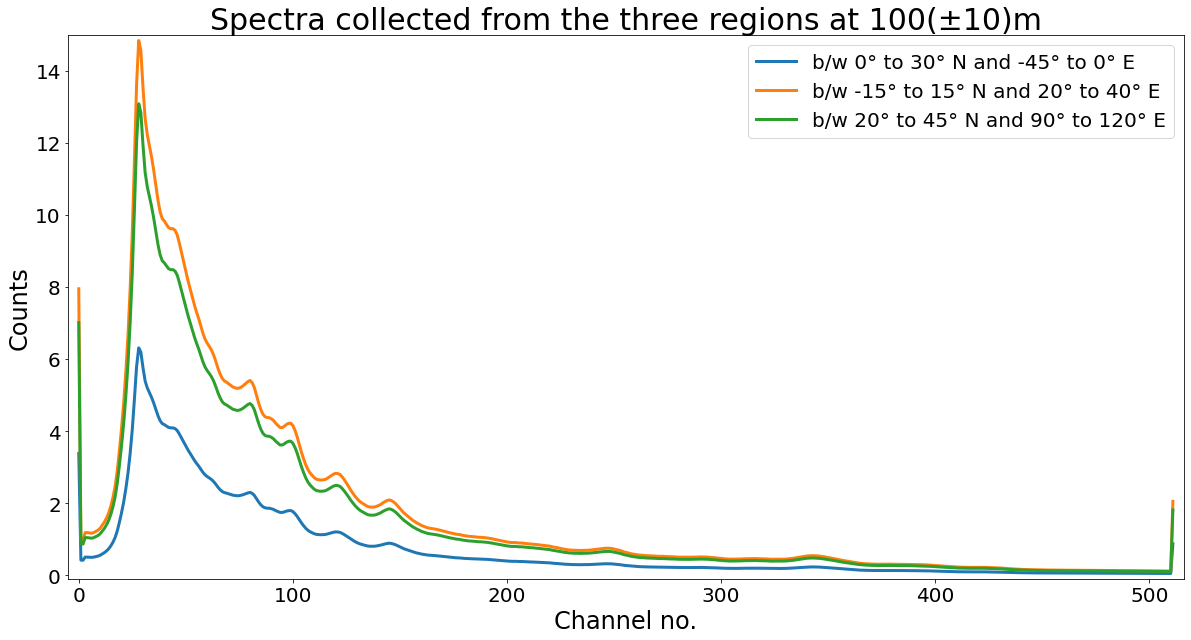

In [17]:
#create and format the figure
plt.figure(figsize=(20,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Channel no.",fontsize=24)
plt.ylabel("Counts",fontsize=24)
plt.title("Spectra collected from the three regions at 100(±10)m",fontsize=30)

#iterate over the dataframe
for i in range(len(normalizedSpectra)):
    #get the spectra
    currentSpectra=normalizedSpectra[i]
    #get the western and eastern most longitude
    westernLongitude=westernLongitudeLimit[i] if westernLongitudeLimit[i]<=180 else westernLongitudeLimit[i]-360
    easternLongitude=easternLongitudeLimit[i] if easternLongitudeLimit[i]<=180 else easternLongitudeLimit[i]-360
    #get the northern and southern most latitude
    northernLatitude=upperLatitudeLimit[i]
    southernLatitude=lowerLatitudeLimit[i]
    #create a label
    label="b/w "+str(southernLatitude)+"\u00B0 to "+str(northernLatitude)+"\u00B0 N and "+str(westernLongitude)+"\u00B0 to "+str(easternLongitude)+"\u00B0 E"
    #plot the spectra
    plt.plot(bandNumbers,currentSpectra,label=label,lw=3)
#change the margin
plt.margins(0.01)
#add legend
plt.legend(fontsize=20,loc="best")

In [18]:
#specify the altitude
desiredAltitude=30
tolerance=3
#specify the lower and upper latitude limits
lowerLatitudeLimit=[0,-15,20]
upperLatitudeLimit=[30,15,45]
#specify the western and eastern longitude limits
westernLongitudeLimit=[315,20,90]
easternLongitudeLimit=[360,40,120]

In [19]:
#create a list of three numpy arrays of 0s to record the summed spectra for each region
summedSpectra30=[np.zeros(512)]*3
#create an empty list to record the no. of spectra in each region
noOfSpectraPerRegion30=[0]*3

#iterate over all .dat .xml file combinations
for currentDatFileURL,currentxmlFileURL in zip(datFileAddresses,xmlFileAddresses):
    #download and read the .dat file
    datFileAddress=saveFile(currentDatFileURL)
    #download and read the .xml file
    xmlFileAddress=saveFile(currentxmlFileURL)
    #read the the data from .dat file into a dataframe 
    currentDataFrame=readGRSData(datFileAddress,xmlFileAddress)
    #iterate over the dataframe
    for i,row in currentDataFrame.iterrows():
        #get the spectra
        currentSpectra=row['Accepted Spectrum']
        #get the altitude
        currentAltitude=row['Altitude']
        #get the latitutude and longitude
        currentLatitude=row['Latitude']
        currentLongitude=row['Longitude']
        #check that the altitude is correct
        if currentAltitude<=desiredAltitude+tolerance and currentAltitude>=desiredAltitude-tolerance:
            #check if the latitude and longitude are in range
            for j in range(len(lowerLatitudeLimit)):
                #check wether the lat long are in range
                if currentLatitude<=upperLatitudeLimit[j] and currentLatitude>=lowerLatitudeLimit[j] and currentLongitude<=easternLongitudeLimit[j] and currentLongitude>=westernLongitudeLimit[j]:
                    #add the current spectra to the summed spectra
                    summedSpectra30[j]+=currentSpectra
                    #increment the number of spectras
                    noOfSpectraPerRegion30[j]+=1
    '''
    #delete the used file from the disk
    os.remove(datFileAddress)
    os.remove(xmlFileAddress)
    '''

In [21]:
#normalize the summed spectra for time
normalizedSpectra30=[np.zeros(512)]*3
#iterate through the summed Spectra
for i in range(len(summedSpectra30)):
    #get the current summed spectra
    currentSummedSpectra=summedSpectra30[i]
    #get the number of spectra
    noOfSpectra=noOfSpectraPerRegion30[i]
    normalizedSpectra30[i]=currentSummedSpectra/(noOfSpectra*32)

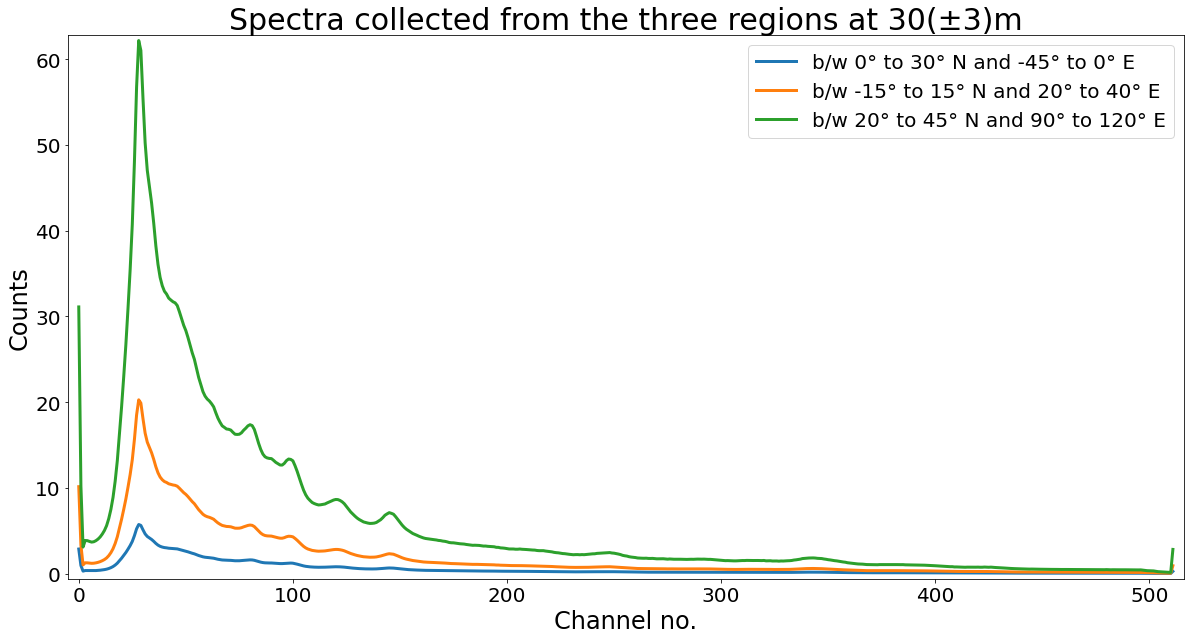

In [23]:
#create and format the figure
plt.figure(figsize=(20,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Channel no.",fontsize=24)
plt.ylabel("Counts",fontsize=24)
plt.title("Spectra collected from the three regions at 30(±3)m",fontsize=30)

#iterate over the dataframe
for i in range(len(normalizedSpectra)):
    #get the spectra
    currentSpectra=normalizedSpectra30[i]
    #get the western and eastern most longitude
    westernLongitude=westernLongitudeLimit[i] if westernLongitudeLimit[i]<=180 else westernLongitudeLimit[i]-360
    easternLongitude=easternLongitudeLimit[i] if easternLongitudeLimit[i]<=180 else easternLongitudeLimit[i]-360
    #get the northern and southern most latitude
    northernLatitude=upperLatitudeLimit[i]
    southernLatitude=lowerLatitudeLimit[i]
    #create a label
    label="b/w "+str(southernLatitude)+"\u00B0 to "+str(northernLatitude)+"\u00B0 N and "+str(westernLongitude)+"\u00B0 to "+str(easternLongitude)+"\u00B0 E"
    #plot the spectra
    plt.plot(bandNumbers,currentSpectra,label=label,lw=3)
#change the margin
plt.margins(0.01)
#add legend
plt.legend(fontsize=20,loc="best")

In [24]:
noOfSpectraPerRegion30

[3834, 1083, 353]

In [26]:
noOfSpectraPerRegion

[12193, 5185, 5880]